# Imaging with Stride

In this notebook, we will apply what we have seen previously to image a 2D section of the human breast using full-waveform inversion (FWI) in Stride.

FWI is a tomographic imaging technique, originally developed in geophysics, that solves a local optimisation problem in order to find the acoustic properties (usually speed of sound) of some imaged region. 

Given some data that we have collected or observed $d_{obs}$ and some data that we have modelled numerically $d_{mod}$, FWI solves the problem,

$$
v_p^* = argmin_{v_p} J(v_p, d_{obs}, d_{mod})
$$
$$
s.t.\; \mathbf{L}(d_{mod}, v_p) = \mathbf{0}
$$

to find the speed of sound $v_p$, where $J(v_p, d_{obs}, d_{mod})$ is a scalar loss function and $\mathbf{L}(d_{mod},v_p) = \mathbf{0}$ is a system of PDEs.

Most generally, we use the L2-norm of the distance between $d_{obs}$ and $d_{mod}$ as the loss function, and the acoustic wave equation as the PDE. The problem then becomes,

$$
v_p^* = argmin_{v_p} \left\langle \frac{1}{2} \left( p(v_p) \delta(\mathbf{x}-\mathbf{x}_0) - d_{obs} \right) ^2, 1 \right\rangle
$$
$$
s.t.\; \frac{1}{v_p^2} \frac{\partial^2 p}{\partial t^2} - \nabla^2 p - s = 0
$$

where $\left\langle \alpha, \beta \right\rangle = \int_{t_0}^{t_1}\int_{\Omega} \alpha \cdot \beta d\mathbf{x}^3dt$ for $t \in [t_0, t_1]$ and $\mathbf{x} \in \Omega$, $\delta(x)$ is the sampling Dirac delta, $\mathbf{x}_0$ is the location of receivers in the region, $p$ is the pressure, and $s$ is a source term.

In FWI, we solve this problem by using a local optimisation method like gradient descent, and we calculate the gradient of the problem using the adjoint method or, what is the same, the procedure that we introduced in the first notebook of this tutorial.

## Mosaic runtime

Before we proceed, let's start the Mosaic runtime.

In [1]:
import mosaic

await mosaic.interactive('on', num_workers=2)
runtime = mosaic.runtime()

HEAD            Listening at <CommsManager object at 140244850362064, uid=head, address=CC2416, port=3000, state=listening>
MONITOR         Listening at <CommsManager object at 140245013478096, uid=monitor, address=CC2416, port=3001, state=listening>
WAREHOUSE       Listening at <CommsManager object at 140245013203664, uid=warehouse, address=CC2416, port=3002, state=listening>
NODE:0          Listening at <CommsManager object at 140245013140240, uid=node:0, address=CC2416, port=3004, state=listening>
WORKER:0:0      Listening at <CommsManager object at 140245013033936, uid=worker:0:0, address=CC2416, port=3013, state=listening>
WORKER:0:1      Listening at <CommsManager object at 140245013057296, uid=worker:0:1, address=CC2416, port=3014, state=listening>


## Problem definition

Let's start by defining out problem as usual, starting with the spatiotemporal grid.

In [2]:
from stride import Space, Time, Grid
%matplotlib notebook

space = Space(shape=(356, 385), extra=(50, 50), absorbing=(40, 40), spacing=0.5e-3)
time = Time(start=0.0e-6, step=0.08e-6, num=2500)

grid = Grid(space, time)

We create the problem object.

In [3]:
from stride import Problem

problem = Problem(name='breast2D', space=space, time=time)

And we start filling it up we our transducers and geometry.

In [4]:
# Create transducers
# the default option will create a single point transducer
problem.transducers.default()

# Create geometry
# a default elliptical geometry will be generated in this case
num_locations = 120
problem.geometry.default('elliptical', num_locations)

We are going to populate our acquisition sequence with 120 shots (one for each location in the geoemtry). During each shot, a different location is going to act as the source and the rest of them are going to act as receivers.

We can easily do this in Stride by calling the `default()` method of the `stride.Acquisitions` object.

In [5]:
from stride.utils import wavelets

# Populate acquisitions with default shots
problem.acquisitions.default()

# Create wavelets
f_centre = 0.50e6
n_cycles = 3

for shot in problem.acquisitions.shots:
    shot.wavelets.data[0, :] = wavelets.tone_burst(f_centre, n_cycles, time.num, time.step)

Now, let's load our breast model.

In [6]:
from stride import ScalarField

# Create medium
vp_true = ScalarField(name='vp', grid=grid)
vp_true.load('../examples/breast2D/data/anastasio2D-TrueModel.h5')

problem.medium.add(vp_true)

To get a plot of all components of the problem together, we can call the utility function `plot()` on the problem object.

<IPython.core.display.Javascript object>


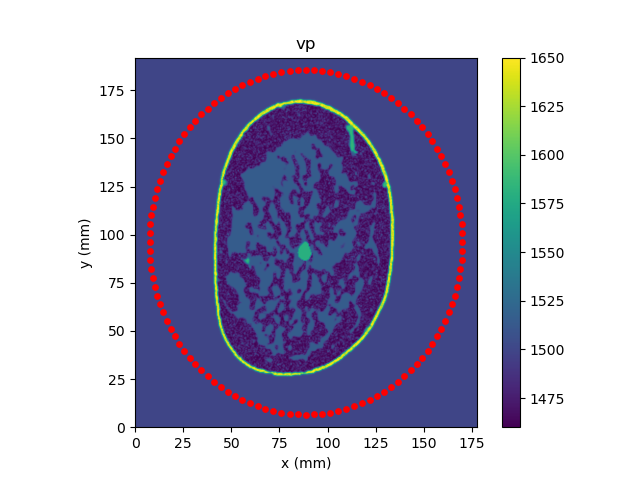

<IPython.core.display.Javascript object>


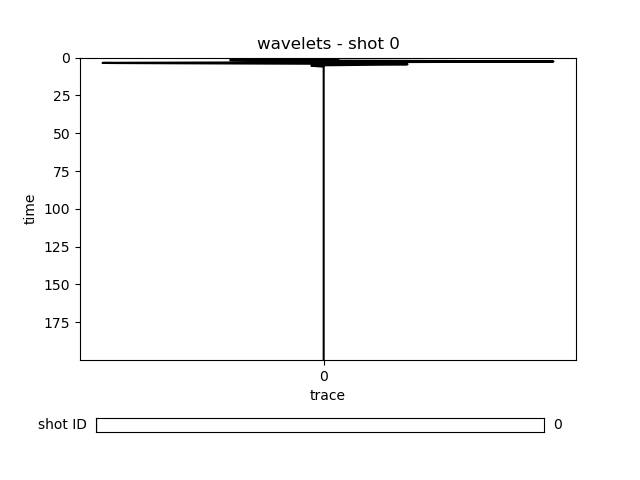

In [7]:
# Plot all components of the problem
problem.plot()

## Modelling operator

Once we have generated our problem, we can create a PDE on which to run our forward problem. In this case, we choose the isotropic acoustic wave equation.

We instantiate our PDE using `remote(len=<num>)` so that instances of the PDE are created in the workers for remote execution. We choose `len=runtime.num_workers` so that one instance is created in each available worker.

In [8]:
from stride import IsoAcousticDevito

pde = IsoAcousticDevito.remote(grid=problem.grid, len=runtime.num_workers)

WORKER:0:0      Default Devito configuration:
WORKER:0:0      	 * autotuning=['aggressive', 'runtime']
WORKER:0:0      	 * develop-mode=False
WORKER:0:0      	 * mpi=False
WORKER:0:1      Default Devito configuration:
WORKER:0:1      	 * autotuning=['aggressive', 'runtime']
WORKER:0:1      	 * develop-mode=False
WORKER:0:1      	 * mpi=False
WORKER:0:0      	 * log-level=DEBUG
WORKER:0:0      	 * language=openmp
WORKER:0:1      	 * log-level=DEBUG
WORKER:0:1      	 * language=openmp


## Forward problem - Generating observed data

Before we can proceed with the imaging bit, we need to simulate the acquisition of some observed data.

Here, we will exploit the parallelisation capabilities of Mosaic to run different shots in parallel in each available worker. We do this with an asynchronous for loop using `@runtime.async_for(<iterable>)`. In the previous code section, the async function `loop()` is called as many times as there are shots in the acquisitions and, for each shot, it is assigned a worker.

HEAD            Giving shot 0 to worker:0:0
HEAD            Giving shot 1 to worker:0:1
WORKER:0:0      (ShotID 0) Preparing to run state for shot
WORKER:0:1      (ShotID 1) Preparing to run state for shot
WORKER:0:1      (ShotID 1) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 0) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 1) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 0) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 1) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 0) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 1) Selected undersampling level 4
WORKER:0:0      (ShotID 0) Selected undersampling level 4
WORKER:0:1      (ShotID 1) Selected time stepping scheme OT2
W

WORKER:0:0      (ShotID 5) Selected undersampling level 4
WORKER:0:0      (ShotID 5) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 5) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 1.17 s
WORKER:0:1      Operator `acoustic_iso_state` ran in 1.31 s
WORKER:0:0      Global performance: [OI=0.01, 17.56 GFlops/s, 0.48 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.15 s [OI=0.01, 17.89 GFlops/s, 0.49 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.02 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=3.17, 0.83 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 5) 

WORKER:0:1      (ShotID 10) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
HEAD            Shot 8 retrieved
HEAD            Retrieved traces for shot 8
HEAD            Giving shot 11 to worker:0:0
WORKER:0:0      (ShotID 11) Preparing to run state for shot
WORKER:0:0      (ShotID 11) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 11) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 11) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 11) Selected undersampling level 4
WORKER:0:0      (ShotID 11) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 11) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 1.02 s
WORKER:0:1      Operator `acoustic_iso_state` ran in 1.10 s
WORKER:0:1      Global performance: [O

WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Global performance: [OI=0.01, 21.21 GFlops/s, 0.58 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.96 s [OI=0.01, 21.46 GFlops/s, 0.58 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.65 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 14) Completed state equation run for shot
HEAD            Shot 14 retrieved
HEAD            Retrieved traces for shot 14
HEAD            Giving shot 17 to worker:0:1
WORKER:0:1      (ShotID 17) Preparing to run state for shot
WORKER:0:1      (ShotID 17) Estimated bandwidth for the propagated wavelet 

HEAD            Retrieved traces for shot 20
HEAD            Giving shot 22 to worker:0:1
WORKER:0:1      (ShotID 22) Preparing to run state for shot
WORKER:0:1      (ShotID 22) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 22) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 22) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 22) Selected undersampling level 4
WORKER:0:1      (ShotID 22) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 22) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Global performance: [OI=0.01, 17.26 GFlops/s, 0.47 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.17 s [OI=0.01, 17.65 GFlops/s, 0.48 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2

WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.83 s
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.71 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 26) Completed state equation run for shot
HEAD            Shot 26 retrieved
HEAD            Retrieved traces for shot 26
HEAD            Giving shot 28 to worker:0:0
WORKER:0:0      (ShotID 28) Preparing to run state for shot
WORKER:0:0      (ShotID 28) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 28) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 28) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotI

WORKER:0:0      (ShotID 33) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 32) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      (ShotID 33) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.58 s
WORKER:0:0      Global performance: [OI=0.01, 35.51 GFlops/s, 0.96 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.57 s [OI=0.01, 36.06 GFlops/s, 0.98 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.27 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 33) C

WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 37) Completed state equation run for shot
HEAD            Shot 37 retrieved
HEAD            Retrieved traces for shot 37
HEAD            Giving shot 39 to worker:0:1
WORKER:0:1      (ShotID 39) Preparing to run state for shot
WORKER:0:1      (ShotID 39) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 39) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 39) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 39) Selected undersampling level 4
WORKER:0:1      (ShotID 39) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 39) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.67 s
WORKER:0:0      Global performance: [OI=0.01, 30.

WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.58 s
WORKER:0:1      Global performance: [OI=0.01, 35.69 GFlops/s, 0.97 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.57 s [OI=0.01, 36.25 GFlops/s, 0.98 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.38 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 43) Completed state equation run for shot
HEAD            Shot 43 retrieved
HEAD            Retrieved traces for shot 43
HEAD            Giving shot 45 to worker:0:1
WORKER:0:1      (ShotID 45) Preparing to run state for shot
WORKER:0:1     

HEAD            Retrieved traces for shot 48
HEAD            Giving shot 50 to worker:0:0
WORKER:0:0      (ShotID 50) Preparing to run state for shot
WORKER:0:0      (ShotID 50) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 50) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 50) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 50) Selected undersampling level 4
WORKER:0:0      (ShotID 50) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 50) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.71 s
WORKER:0:1      Global performance: [OI=0.01, 29.19 GFlops/s, 0.79 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.70 s [OI=0.01, 29.57 GFl

WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.56 s [OI=0.01, 37.27 GFlops/s, 1.01 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.59 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 54) Completed state equation run for shot
HEAD            Shot 54 retrieved
HEAD            Retrieved traces for shot 54
HEAD            Giving shot 56 to worker:0:0
WORKER:0:0      (ShotID 56) Preparing to run state for shot
WORKER:0:0      (ShotID 56) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 56) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm

WORKER:0:1      (ShotID 61) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 61) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 61) Selected undersampling level 4
WORKER:0:1      (ShotID 61) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 61) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.89 s
WORKER:0:0      Global performance: [OI=0.01, 23.21 GFlops/s, 0.63 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.88 s [OI=0.01, 23.46 GFlops/s, 0.64 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>

HEAD            Shot 64 retrieved
HEAD            Retrieved traces for shot 64
HEAD            Giving shot 67 to worker:0:0
WORKER:0:1      (ShotID 66) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 66) Selected undersampling level 4
WORKER:0:1      (ShotID 66) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 66) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      (ShotID 67) Preparing to run state for shot
WORKER:0:0      (ShotID 67) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 67) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 67) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 67) Selected undersampling level 4
WORKER:0:0      (ShotID 67) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 67) Running state equation for s

WORKER:0:1      (ShotID 72) Selected undersampling level 4
WORKER:0:1      (ShotID 72) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 72) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Global performance: [OI=0.01, 22.38 GFlops/s, 0.61 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.91 s [OI=0.01, 22.64 GFlops/s, 0.61 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.76 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 71) Completed state equation run for shot
HEAD            Shot 71 retrieved
HEAD            Retrieved traces for shot 71

WORKER:0:1      (ShotID 76) Completed state equation run for shot
HEAD            Shot 76 retrieved
HEAD            Retrieved traces for shot 76
HEAD            Giving shot 78 to worker:0:1
WORKER:0:1      (ShotID 78) Preparing to run state for shot
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.96 s
WORKER:0:1      (ShotID 78) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 78) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 78) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 78) Selected undersampling level 4
WORKER:0:1      (ShotID 78) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 78) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Global performance: [OI=0.01, 21.55 GFlops/s, 0.59 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499

HEAD            Shot 82 retrieved
HEAD            Retrieved traces for shot 82
HEAD            Giving shot 83 to worker:0:1
WORKER:0:1      (ShotID 83) Preparing to run state for shot
WORKER:0:1      (ShotID 83) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 83) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 83) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 83) Selected undersampling level 4
WORKER:0:1      (ShotID 83) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 83) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
HEAD            Shot 81 retrieved
HEAD            Retrieved traces for shot 81
HEAD            Giving shot 84 to worker:0:0
WORKER:0:0      (ShotID 84) Preparing to run state for shot
WORKER:0:0      (ShotID 84) Estimated bandwidth for the propagated wavelet 0.255-0.735

HEAD            Giving shot 89 to worker:0:1
WORKER:0:1      (ShotID 89) Preparing to run state for shot
WORKER:0:1      (ShotID 89) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 89) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 89) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 89) Selected undersampling level 4
WORKER:0:1      (ShotID 89) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 89) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 1.53 s
WORKER:0:0      Global performance: [OI=0.01, 13.48 GFlops/s, 0.37 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.51 s [OI=0.01, 13.62 GFlops/s, 0.37 GPts/s]
WORKER:0:0        * secti

WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.81 s [OI=0.01, 25.38 GFlops/s, 0.69 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.74 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 93) Completed state equation run for shot
HEAD            Shot 93 retrieved
HEAD            Retrieved traces for shot 93
HEAD            Giving shot 95 to worker:0:1
WORKER:0:1      (ShotID 95) Preparing to run state for shot
WORKER:0:1      (ShotID 95) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 95) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (Shot

WORKER:0:1      (ShotID 100) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 100) Selected undersampling level 4
WORKER:0:1      (ShotID 100) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 100) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      (ShotID 99) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.70 s
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.69 s
WORKER:0:1      Global performance: [OI=0.01, 29.37 GFlops/s, 0.80 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.69 s [OI=0.01, 29.75 GFlops/s, 0.81 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<24

WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.92 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 104) Completed state equation run for shot
HEAD            Shot 104 retrieved
HEAD            Retrieved traces for shot 104
HEAD            Giving shot 106 to worker:0:0
WORKER:0:0      (ShotID 106) Preparing to run state for shot
WORKER:0:0      (ShotID 106) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 106) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      (ShotID 106) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:0      (ShotID 106) Selected undersampling level 4
WORKER:0:0    

WORKER:0:1      (ShotID 111) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 111) Selected undersampling level 4
WORKER:0:1      (ShotID 111) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 111) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.52 s
WORKER:0:0      Global performance: [OI=0.01, 39.87 GFlops/s, 1.08 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.51 s [OI=0.01, 40.40 GFlops/s, 1.09 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.89 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_no

WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.88 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 115) Completed state equation run for shot
HEAD            Shot 115 retrieved
HEAD            Retrieved traces for shot 115
HEAD            Giving shot 117 to worker:0:1
WORKER:0:1      (ShotID 117) Preparing to run state for shot
WORKER:0:1      (ShotID 117) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 117) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      (ShotID 117) Time grid spacing (0.080 μs | 26%) is below OT2 limit (0.136 μs)
WORKER:0:1      (ShotID 117) Selected undersampling level 4
WORKER:0:1      (ShotID 117) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 117) Running state equation for shot
WORKER:0:1      A

<IPython.core.display.Javascript object>


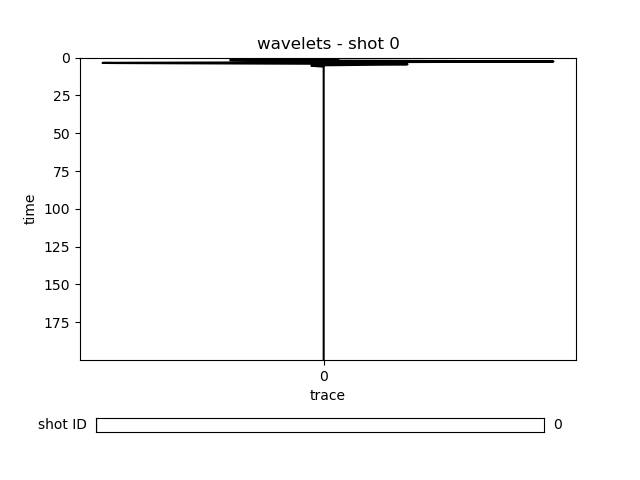

<IPython.core.display.Javascript object>


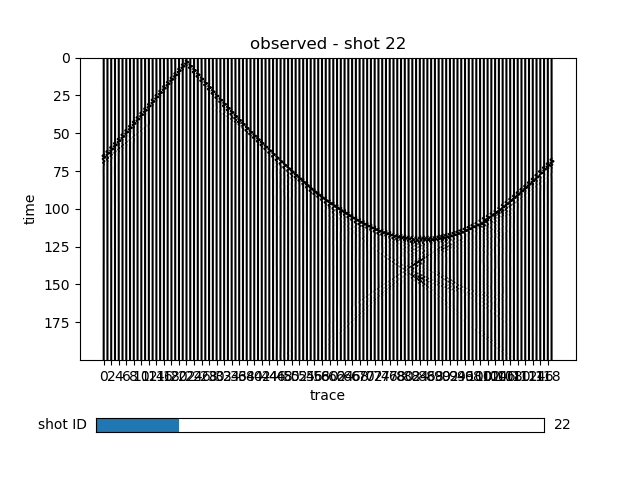

In [9]:
# Get all remaining shot IDs
shot_ids = problem.acquisitions.remaining_shot_ids

# Run an asynchronous loop across all shot IDs
@runtime.async_for(shot_ids)
async def loop(worker, shot_id):
    runtime.logger.info('Giving shot %d to %s' % (shot_id, worker.uid))

    # Fetch one sub-problem corresponding to a shot ID
    sub_problem = problem.sub_problem(shot_id)
    
    # Access the source wavelets of this shot
    wavelets = sub_problem.shot.wavelets
    
    # Execute the PDE forward
    traces = await pde(wavelets, vp_true,
                       problem=sub_problem,
                       runtime=worker).result()

    runtime.logger.info('Shot %d retrieved' % sub_problem.shot_id)

    # Store the retrieved traces into the shot
    shot = problem.acquisitions.get(shot_id)
    shot.observed.data[:] = traces.data

    runtime.logger.info('Retrieved traces for shot %d' % sub_problem.shot_id)

# Because this is an asynchronous loop, it needs to be awaited 
_ = await loop

# Plot the result
_ = problem.acquisitions.plot()

Because the loop we just ran is a very common piece of code, we can obtain the same result by running the utility function `forward()`:

In [ ]:
from stride import forward

# Run default forward workflow
# await forward(problem, pde, vp_true, dump=False)  # uncomment to run using utility function

## Starting model

Before we can proceed with the imaging process, we need to determine a starting point for our inversion, a starting model.

In [10]:
vp = ScalarField.parameter(name='vp', grid=grid, needs_grad=True)
vp.fill(1500.)

problem.medium.add(vp)

Unlike our forward example, the speed-of-sound field is unknown to us at this point. So, we define our starting guess for the speed of sound to be homogeneous with a value of 1500 m/s. Because we are going to run our inversion with respect to `vp`, we also define the field with `needs_grad=True`. That will instruct Stride to calculate the gradient of this variable when running the optimisation loop.

You can also see that the field has now been instantiated using `parameter()`. This will turn `vp` into a remotely addressable object. What this means is that, as `vp` travels through our Mosaic network, it will always keep a reference to its original object here in our code. This will effectively allow us to accumulate the gradients calculated across different workers into a single local buffer.

## Imaging operators

Apart from our PDE operator, which we have already defined above, we will need to define an operator for our loss function:

In [11]:
from stride import L2DistanceLoss 

loss = L2DistanceLoss.remote(len=runtime.num_workers)

We will also need some operators to proprocess the source wavelents and the modelled and observed data traces:

In [12]:
from stride import ProcessWavelets, ProcessTraces

process_wavelets = ProcessWavelets.remote(len=runtime.num_workers)
process_traces = ProcessTraces.remote(len=runtime.num_workers)

Finally, we will need an optimiser to update the speed of sound model after each iteration. In this case, we use gradient descent.

In [13]:
from stride import GradientDescent, ProcessGlobalGradient, ProcessModelIteration

step_size = 10
process_grad = ProcessGlobalGradient()
process_model = ProcessModelIteration(min=1400., max=1700.)

optimiser = GradientDescent(vp, step_size=step_size,
                            process_grad=process_grad,
                            process_model=process_model)

You can see that we have also provided to the optimiser some pre-defined processing steps. These will be used to prepare the gradient before updating the variable, and to process the variable after the update. 

Among other things, these processing steps will normalise and smooth the gradient, and will clip the speed of sound of the updated model between 1400 m/s and 1700 m/s.

## Inverse problem - Estimating speed of sound

We can now proceed to solve the inverse problem, that is finding the speed of sound that explains the data that we have generated above.

To obtain a better posed optimisation, we use a multi-scale approach. We will start our inversion by using only low frequencies to construct our model. As the inversion progresses, we will add higher frequencies until we reach the maximum desired level of detail.

We can do this by dividing our optimisation in `Block`s and specifying a maximum frequency. Each `Block` will run for a number of specified iterations.

During each iteration, only a subset of the shots will be used by defining the `select_shots` field. In this case, 15 shots will be used for each iteration, and they will be selected randomly without replacement.

HEAD            Starting iteration 1 (out of 4), block 1 (out of 2)
HEAD            Giving shot 7 to worker:0:0
HEAD            Giving shot 15 to worker:0:1
WORKER:0:1      (ShotID 15) Preparing to run state for shot
WORKER:0:1      (ShotID 15) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 15) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:0      (ShotID 7) Preparing to run state for shot
WORKER:0:1      (ShotID 15) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:0      (ShotID 7) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 15) Selected undersampling level 4
WORKER:0:0      (ShotID 7) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:1      (ShotID 15) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 7) Time grid spacing (0.080 μs | 24%) is below OT2 l

WORKER:0:1      (ShotID 33) Selected time stepping scheme OT2
HEAD            Retrieved gradient for shot 7
HEAD            Giving shot 41 to worker:0:0
WORKER:0:0      (ShotID 41) Preparing to run state for shot
WORKER:0:0      (ShotID 41) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 41) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:0      (ShotID 41) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:0      (ShotID 41) Selected undersampling level 4
WORKER:0:0      (ShotID 41) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 33) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      (ShotID 41) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 1.02 s
WORKER:0:0      Operator `acoustic_iso_state` ran in 1.02 s
WORKER:

WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 46) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 46
HEAD            Giving shot 54 to worker:0:1
WORKER:0:1      (ShotID 54) Preparing to run state for shot
WORKER:0:1      (ShotID 54) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 1.38 s
WORKER:0:1      (ShotID 54) Spatial grid spacing (0.500 mm | 4.082 PPW) is higher than dispersion limit (0.408 mm | 5.000 PPW)
WORKER:0:1      (ShotID 54) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:1      (ShotID 54) Selected undersampling level 4
WORKER:0:1      (ShotID 54) Selected time stepping scheme OT2
WORKER:0:0      Global performance: [OI=0.01, 20.91 GFlops/s, 0.41 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456

WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.17 s [OI=0.01, 17.57 GFlops/s, 0.48 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.49 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 95) Completed state equation run for shot
HEAD            Functional value for shot 95: loss 3.271927e+00 for shot 95
WORKER:0:0      (ShotID 95) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 95) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 1.54 s
WORKER:0:1      Global performance: [OI=0.01, 18.72 GFlops/s, 0.36 GPts/

WORKER:0:0      (ShotID 109) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.150 μs)
WORKER:0:0      (ShotID 109) Selected undersampling level 4
WORKER:0:0      (ShotID 109) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 109) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.61 s
WORKER:0:1      Global performance: [OI=0.01, 33.80 GFlops/s, 0.91 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.56 s [OI=0.01, 36.67 GFlops/s, 0.99 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.31 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_no

WORKER:0:0      Global performance: [OI=0.01, 36.31 GFlops/s, 0.98 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.52 s [OI=0.01, 39.53 GFlops/s, 1.07 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.34 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 0) Completed state equation run for shot
HEAD            Functional value for shot 0: loss 1.405107e+00 for shot 0
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.67 s
WORKER:0:0      (ShotID 0) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 0) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORK

WORKER:0:1      Global performance: [OI=0.01, 21.70 GFlops/s, 0.42 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.97 s [OI=0.01, 21.17 GFlops/s, 0.58 GPts/s]
WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=2.82, 0.83 GFlops/s, 0.02 GPts/s]
WORKER:0:1        * section2<2499,456,485> ran in 0.35 s [OI=0.94, 24.19 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 25) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 25
HEAD            Giving shot 38 to worker:0:1
WORKER:0:1      (ShotID 38) Preparing to run state for shot
WORKER:0:1      (ShotID 38) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 38) Spatial grid spacing (0.500 mm | 4.057 PPW) is higher than dispersion limit (0.406

WORKER:0:0      Global performance: [OI=0.01, 23.70 GFlops/s, 0.46 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.90 s [OI=0.01, 22.94 GFlops/s, 0.62 GPts/s]
WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=2.82, 1.00 GFlops/s, 0.03 GPts/s]
WORKER:0:0        * section2<2499,456,485> ran in 0.31 s [OI=0.94, 26.95 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 42) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 42
HEAD            Giving shot 52 to worker:0:0
WORKER:0:0      (ShotID 52) Preparing to run state for shot
WORKER:0:0      (ShotID 52) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 52) Spatial grid spacing (0.500 mm | 4.057 PPW) is higher than dispersion limit (0.406

WORKER:0:0      (ShotID 62) Completed state equation run for shot
HEAD            Functional value for shot 62: loss 2.073178e+00 for shot 62
WORKER:0:0      (ShotID 62) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 62) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 1.34 s
WORKER:0:1      Global performance: [OI=0.01, 15.33 GFlops/s, 0.42 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.25 s [OI=0.01, 16.53 GFlops/s, 0.45 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.28 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}

HEAD            Retrieved gradient for shot 71
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.68 s
WORKER:0:0      Global performance: [OI=0.01, 30.56 GFlops/s, 0.83 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.61 s [OI=0.01, 33.93 GFlops/s, 0.92 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.02 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.28 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 90) Completed state equation run for shot
HEAD            Functional value for shot 90: loss 2.618045e+00 for shot 90
WORKER:0:0      (ShotID 90) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 90) Running adjoint equation for shot
WORKER

WORKER:0:1      (ShotID 36) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 22) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      (ShotID 36) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.60 s
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.58 s
WORKER:0:0      Global performance: [OI=0.01, 34.52 GFlops/s, 0.93 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.55 s [OI=0.01, 37.58 GFlops/s, 1.02 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.29 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads

WORKER:0:1        * section2<2499,456,485> ran in 0.20 s [OI=0.94, 42.20 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 60) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 47
HEAD            Giving shot 68 to worker:0:0
WORKER:0:0      (ShotID 68) Preparing to run state for shot
WORKER:0:0      (ShotID 68) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 68) Spatial grid spacing (0.500 mm | 4.053 PPW) is higher than dispersion limit (0.405 mm | 5.000 PPW)
WORKER:0:0      (ShotID 68) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.149 μs)
WORKER:0:0      (ShotID 68) Selected undersampling level 4
WORKER:0:0      (ShotID 68) Selected time stepping scheme OT2
HEAD            Retrieved gradient for shot 60
HEAD            Giving shot 76 to worker:0:1
WORKER:0:1      (ShotID 76) Preparing to run state for shot
WORKER:0:1      (S

HEAD            Functional value for shot 89: loss 1.764314e+00 for shot 89
WORKER:0:0      (ShotID 89) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 89) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.80 s
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.82 s
WORKER:0:1      Global performance: [OI=0.01, 36.21 GFlops/s, 0.70 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.57 s [OI=0.01, 36.00 GFlops/s, 0.97 GPts/s]
WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=2.82, 1.22 GFlops/s, 0.03 GPts/s]
WORKER:0:1        * section2<2499,456,485> ran in 0.22 s [OI=0.94, 38.66 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 86) Completed adjoi

WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.47 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 94) Completed state equation run for shot
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.85 s
WORKER:0:0      Global performance: [OI=0.01, 24.17 GFlops/s, 0.66 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.80 s [OI=0.01, 25.96 GFlops/s, 0.70 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.93 G

WORKER:0:0      (ShotID 2) Completed state equation run for shot
HEAD            Functional value for shot 2: loss 1.490894e+00 for shot 2
WORKER:0:0      (ShotID 2) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 2) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Global performance: [OI=0.01, 19.96 GFlops/s, 0.54 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.96 s [OI=0.01, 21.56 GFlops/s, 0.59 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.37 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 4) Completed state equation run for shot

HEAD            Giving shot 18 to worker:0:1
WORKER:0:1      (ShotID 18) Preparing to run state for shot
WORKER:0:1      (ShotID 18) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 18) Spatial grid spacing (0.500 mm | 4.040 PPW) is higher than dispersion limit (0.404 mm | 5.000 PPW)
WORKER:0:1      (ShotID 18) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.148 μs)
WORKER:0:1      (ShotID 18) Selected undersampling level 4
WORKER:0:1      (ShotID 18) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 18) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 1.07 s
WORKER:0:0      Global performance: [OI=0.01, 19.29 GFlops/s, 0.52 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.99 s [OI=0.01, 20.77 GFlops/s, 0.56 GPts/s]
WORKER:0:0        * secti

HEAD            Giving shot 49 to worker:0:0
WORKER:0:0      (ShotID 49) Preparing to run state for shot
WORKER:0:0      (ShotID 49) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 49) Spatial grid spacing (0.500 mm | 4.040 PPW) is higher than dispersion limit (0.404 mm | 5.000 PPW)
WORKER:0:0      (ShotID 49) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.148 μs)
WORKER:0:0      (ShotID 49) Selected undersampling level 4
WORKER:0:0      (ShotID 49) Selected time stepping scheme OT2
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.90 s
WORKER:0:0      (ShotID 49) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Global performance: [OI=0.01, 32.08 GFlops/s, 0.62 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.72 s [OI=0.01, 28.85 GFlops/s, 0.78 GPts/s]
WORKER:0:1        * sec

WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.14 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 88) Completed state equation run for shot
HEAD            Functional value for shot 88: loss 1.996223e+00 for shot 88
WORKER:0:1      (ShotID 88) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 88) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.91 s
WORKER:0:0      Global performance: [OI=0.01, 31.85 GFlops/s, 0.62 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.68 s [OI=0.01, 30.27 GFlops/s, 0.82 GPts/

WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 119) Completed state equation run for shot
HEAD            Functional value for shot 119: loss 1.627940e+00 for shot 119
WORKER:0:0      (ShotID 119) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 119) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.57 s
WORKER:0:0      Global performance: [OI=0.01, 50.83 GFlops/s, 0.98 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.45 s [OI=0.01, 45.75 GFlops/s, 1.24 GPts/s]
WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.69 GFlops/s, 0.04 GPts/s]
WORKER:0:0        * section2<2499,456,485> ran in 0.12 s [OI=0.94, 75.12 GFlops/s]
WORKER:0:0      Performance[mode=a

WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=3.17, 1.10 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 27) Completed state equation run for shot
HEAD            Functional value for shot 27: loss 2.140169e+00 for shot 27
WORKER:0:0      (ShotID 27) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 27) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Global performance: [OI=0.01, 10.57 GFlops/s, 0.29 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.83 s [OI=0.01, 11.22 GFlops/s, 0.31 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<24

WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 57) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 57
HEAD            Giving shot 59 to worker:0:1
WORKER:0:1      (ShotID 59) Preparing to run state for shot
WORKER:0:1      (ShotID 59) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 59) Spatial grid spacing (0.500 mm | 4.039 PPW) is higher than dispersion limit (0.404 mm | 5.000 PPW)
WORKER:0:1      (ShotID 59) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.148 μs)
WORKER:0:1      (ShotID 59) Selected undersampling level 4
WORKER:0:1      (ShotID 59) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 58) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      (ShotID 59) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator 

WORKER:0:1        * section2<2499,456,485> ran in 0.36 s [OI=0.94, 23.18 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 80) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 80
HEAD            Giving shot 82 to worker:0:1
WORKER:0:1      (ShotID 82) Preparing to run state for shot
WORKER:0:1      (ShotID 82) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 82) Spatial grid spacing (0.500 mm | 4.039 PPW) is higher than dispersion limit (0.404 mm | 5.000 PPW)
WORKER:0:1      (ShotID 82) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.148 μs)
WORKER:0:1      (ShotID 82) Selected undersampling level 4
WORKER:0:1      (ShotID 82) Selected time stepping scheme OT2
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 1.71 s
WORKER:0:0      Global performance: [OI=0.01, 16.90 GFlops/s, 0.33 GPts/s]
WORKER:0:0      Local performance

WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.02 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.19 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 115) Completed state equation run for shot
WORKER:0:0      (ShotID 114) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 114) Running adjoint equation for shot
HEAD            Functional value for shot 115: loss 1.579279e+00 for shot 115
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      (ShotID 115) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 115) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 2.00 s
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 2.08 s
WORKER:0:0    

WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 17) Completed state equation run for shot
HEAD            Functional value for shot 17: loss 1.459683e+00 for shot 17
WORKER:0:1      (ShotID 17) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 17) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 1.08 s
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.88 s
WORKER:0:0      Global performance: [OI=0.01, 26.91 GFlops/s, 0.52 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.81 s [OI=0.01, 25.36 GFlops/s, 0.69 GPts/s]
WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=2.82, 1.04 GFlops/s, 0.03 GPts/s]
WORKER:0:0        * section2<2499,456,485> ran in 0.25 s [OI

WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.56 s [OI=0.01, 36.65 GFlops/s, 0.99 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.04 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 2.11 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 24) Completed state equation run for shot
HEAD            Functional value for shot 24: loss 1.957138e+00 for shot 24
WORKER:0:0      (ShotID 24) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 24) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.67 s
WORKER:0:1      Global performance: [OI=0.01, 30.91 GFlops/s, 0.84 GPts/s]
WORKER:0:1      Local performance:

WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=2.82, 1.45 GFlops/s, 0.04 GPts/s]
WORKER:0:1        * section2<2499,456,485> ran in 0.18 s [OI=0.94, 46.31 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 73) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 73
HEAD            Giving shot 79 to worker:0:1
WORKER:0:1      (ShotID 79) Preparing to run state for shot
WORKER:0:1      (ShotID 79) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 79) Spatial grid spacing (0.500 mm | 4.028 PPW) is higher than dispersion limit (0.403 mm | 5.000 PPW)
WORKER:0:1      (ShotID 79) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.148 μs)
WORKER:0:1      (ShotID 79) Selected undersampling level 4
WORKER:0:1      (ShotID 79) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 75) Runni

WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.94 s [OI=0.01, 21.83 GFlops/s, 0.59 GPts/s]
WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=2.82, 0.88 GFlops/s, 0.02 GPts/s]
WORKER:0:0        * section2<2499,456,485> ran in 0.29 s [OI=0.94, 29.14 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 85) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 85
HEAD            Giving shot 101 to worker:0:0
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 1.28 s
WORKER:0:0      (ShotID 101) Preparing to run state for shot
WORKER:0:0      (ShotID 101) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 101) Spatial grid spacing (0.500 mm | 4.028 PPW) is higher than dispersion limit (0.403 mm | 5.000 PPW)
WORKER:0:0      (ShotID 101

WORKER:0:0        * section2<2499,456,485> ran in 0.20 s [OI=0.94, 41.81 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 107) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 107
HEAD            Updating variable vp,
HEAD            	 direction before processing in range [-4.937460e+02, 2.188238e+02]
HEAD            	 direction after processing in range [-1.000000e+00, 4.430418e-01]
HEAD            	 variable range before update [1.480160e+03, 1.524391e+03]
HEAD            	 variable range after update [1.480553e+03, 1.529702e+03]
HEAD            Done iteration 2 (out of 4), block 2 (out of 2) - Total loss_freq 2.161837e+01
HEAD            ====================================================================
HEAD            Starting iteration 3 (out of 4), block 2 (out of 2)
HEAD            Giving shot 3 to worker:0:0
HEAD            Giving shot 6 to worker:0:1
WORKER:0:0 

WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.67 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 29) Completed state equation run for shot
HEAD            Functional value for shot 29: loss 1.730054e+00 for shot 29
WORKER:0:1      (ShotID 29) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 29) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 1.24 s
WORKER:0:0      Global performance: [OI=0.01, 23.30 GFlops/s, 0.45 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.95 s [OI=0.01, 21.73 GFlops/s, 0.59 GPts/

WORKER:0:1      (ShotID 51) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 1.00 s
WORKER:0:0      Global performance: [OI=0.01, 20.72 GFlops/s, 0.56 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.89 s [OI=0.01, 23.13 GFlops/s, 0.63 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.69 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 50) Completed state equation run for shot
HEAD            Functional value for shot 50: loss 1.158540e+00 for shot 50
WORKER:0:0      (ShotID 50) Preparing to run adjoint for shot
W

WORKER:0:0      (ShotID 98) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.84 s
WORKER:0:1      Global performance: [OI=0.01, 34.35 GFlops/s, 0.66 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.66 s [OI=0.01, 31.32 GFlops/s, 0.85 GPts/s]
WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=2.82, 1.19 GFlops/s, 0.03 GPts/s]
WORKER:0:1        * section2<2499,456,485> ran in 0.18 s [OI=0.94, 48.08 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 87) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 87
HEAD            Giving shot 110 to worker:0:1
WORKER:0:1      (ShotID 110) Preparing to run state for shot
WORKER:0:1      (ShotID

WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.01 s [OI=3.17, 1.87 GFlops/s]
WORKER:0:0        * section2<2499,456,485> ran in 0.17 s [OI=0.94, 49.22 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 113) Completed state equation run for shot
WORKER:0:0      (ShotID 112) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 112
HEAD            Giving shot 116 to worker:0:0
HEAD            Functional value for shot 113: loss 1.121040e+00 for shot 113
WORKER:0:0      (ShotID 116) Preparing to run state for shot
WORKER:0:0      (ShotID 116) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:1      (ShotID 113) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 116) Spatial grid spacing (0.500 mm | 4.029 

WORKER:0:0        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=2.82, 0.90 GFlops/s, 0.02 GPts/s]
WORKER:0:0        * section2<2499,456,485> ran in 0.32 s [OI=0.94, 26.03 GFlops/s]
WORKER:0:0      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 12) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 12
HEAD            Giving shot 34 to worker:0:0
WORKER:0:0      (ShotID 34) Preparing to run state for shot
WORKER:0:0      (ShotID 34) Estimated bandwidth for the propagated wavelet 0.255-0.735 MHz
WORKER:0:0      (ShotID 34) Spatial grid spacing (0.500 mm | 4.019 PPW) is higher than dispersion limit (0.402 mm | 5.000 PPW)
WORKER:0:0      (ShotID 34) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.147 μs)
WORKER:0:0      (ShotID 34) Selected undersampling level 4
WORKER:0:0      (ShotID 34) Selected time stepping scheme OT2
WORKER:0:1      Operator `acousti

WORKER:0:1      Operator `acoustic_iso_state` ran in 1.27 s
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Global performance: [OI=0.01, 16.19 GFlops/s, 0.44 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.16 s [OI=0.01, 17.79 GFlops/s, 0.48 GPts/s]
WORKER:0:1        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.02 s [OI=2.82, 0.02 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=3.17, 1.06 GFlops/s]
WORKER:0:1      Performance[mode=advanced] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 53) Completed state equation run for shot
HEAD            Functional value for shot 53: loss 1.104062e+00 for shot 53
WORKER:0:1      (ShotID 53) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 53) Running adjoint equation for shot

WORKER:0:1      (ShotID 67) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.147 μs)
WORKER:0:1      (ShotID 67) Selected undersampling level 4
WORKER:0:1      (ShotID 67) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 66) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      (ShotID 67) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.93 s
WORKER:0:1      Operator `acoustic_iso_state` ran in 1.01 s
WORKER:0:0      Global performance: [OI=0.01, 22.10 GFlops/s, 0.60 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 0.86 s [OI=0.01, 23.99 GFlops/s, 0.65 GPts/s]
WORKER:0:0        * section1<<2499,1>,<2499,1>,<2499,1>,<2499,1>,<2499,1>> ran in 0.01 s [OI=2.82, 0.03 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,1

WORKER:0:0      (ShotID 84) Spatial grid spacing (0.500 mm | 4.019 PPW) is higher than dispersion limit (0.402 mm | 5.000 PPW)
WORKER:0:0      (ShotID 84) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.147 μs)
WORKER:0:0      (ShotID 84) Selected undersampling level 4
WORKER:0:0      (ShotID 84) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 84) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 1.34 s
WORKER:0:1      Global performance: [OI=0.01, 21.53 GFlops/s, 0.42 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<<2499,376,405>,<2499,40,405>,<2499,40,405>,<2499,456,40>,<2499,456,40>> ran in 1.03 s [OI=0.01, 20.02 GFlops/s, 0.54 GPts/s]
WORKER:0:1        * section1<<2499,120>,<2499,120>,<2499,120>,<2499,120>,<2499,120>> ran in 0.02 s [OI=2.82, 0.79 GFlops/s, 0.02 GPts/s]
WORKER:0:1        * section2<2499,456,485> ran in 0.30 s [OI=0.94, 28.00 GFlops/s]

HEAD            ====================================================================


<IPython.core.display.Javascript object>


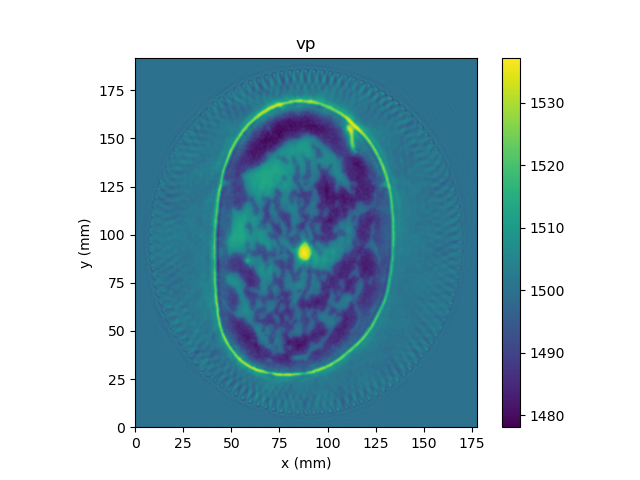

<AxesSubplot:title={'center':'vp'}, xlabel='x (mm)', ylabel='y (mm)'>

In [14]:
from stride import OptimisationLoop

# Clear the previous Devito operators
await pde.clear_operators()

optimisation_loop = OptimisationLoop()

# Specify a series of frequency bands, which we will introduce gradually 
# into the inversion in order to better condition it
f_min = 0.05e6
max_freqs = [0.3e6, 0.4e6]

num_blocks = len(max_freqs)
num_iters = 4

# Start iterating over each block in the optimisation
for block, f_max in optimisation_loop.blocks(num_blocks, max_freqs):

    # Proceed through every iteration in the block
    for iteration in block.iterations(num_iters):
        runtime.logger.info('Starting iteration %d (out of %d), '
                            'block %d (out of %d)' %
                            (iteration.id+1, block.num_iterations, block.id+1,
                             optimisation_loop.num_blocks))

        # Select some shots for this iteration
        shot_ids = problem.acquisitions.select_shot_ids(num=15, randomly=True)

        # Clear the gradient buffers of the variable
        vp.clear_grad()
        
        # Make latest version of the variable available for the workers
        await vp.push()

        # Asynchronously loop over all the selected shot IDs
        @runtime.async_for(shot_ids)
        async def loop(worker, shot_id):
            runtime.logger.info('Giving shot %d to %s' % (shot_id, worker.uid))

            # Fetch one sub-problem corresponding to the shot ID
            sub_problem = problem.sub_problem(shot_id)
            wavelets = sub_problem.shot.wavelets
            observed = sub_problem.shot.observed

            # Pre-process the wavelets
            wavelets = process_wavelets(wavelets, f_min=f_min, f_max=f_max, runtime=worker)
            # Execute the PDE forward
            modelled = pde(wavelets, vp, problem=sub_problem, runtime=worker)

            # Pre-process the modelled and observed traces
            traces = process_traces(modelled, observed, f_min=f_min, f_max=f_max, runtime=worker)
            # and use these pre-processed versions to calculate the
            # value of the loss_freq function
            fun = await loss(traces.outputs[0], traces.outputs[1],
                             problem=sub_problem, runtime=worker).result()

            iteration.add_fun(fun)
            runtime.logger.info('Functional value for shot %d: %s' % (shot_id, fun))

            # Now, we can calculate the gradient by executing the adjoint of the
            # forward process
            await fun.adjoint()

            runtime.logger.info('Retrieved gradient for shot %d' % sub_problem.shot_id)

        # Because this is an async loop, it needs to be awaited    
        _ = await loop
        # Bring to the local process the accumulated gradient
        await vp.pull()
        # Update the vp with the calculated gradient by taking a step with the optimiser
        await optimiser.step()

        runtime.logger.info('Done iteration %d (out of %d), '
                            'block %d (out of %d) - Total loss_freq %e' %
                            (iteration.id+1, block.num_iterations, block.id+1,
                             optimisation_loop.num_blocks, iteration.fun_value))
        runtime.logger.info('====================================================================')

# Plot the vp afterwards   
vp.plot()

As was the case for the forward example, we can obtain the same result by using a utility function that will run the default inversion workflow using `adjoint`:

In [ ]:
# uncomment to run using utility function
# for block, freq in optimisation_loop.blocks(num_blocks, max_freqs):
#     await adjoint(problem, pde, loss_freq,
#                   optimisation_loop, optimiser, vp,
#                   num_iters=num_iters,
#                   select_shots=dict(num=15, randomly=True),
#                   f_min=0.05e6, f_max=freq)

# vp.plot()

Before closing, we should tear down the mosaic runtime:

In [15]:
await mosaic.interactive('off')